In [ ]:
import clr, os, winreg
from itertools import islice

# This boilerplate requires the 'pythonnet' module.
# The following instructions are for installing the 'pythonnet' module via pip:
#    1. Ensure you are running Python 3.4, 3.5, 3.6, or 3.7. PythonNET does not work with Python 3.8 yet.
#    2. Install 'pythonnet' from pip via a command prompt (type 'cmd' from the start menu or press Windows + R and type 'cmd' then enter)
#
#        python -m pip install pythonnet

# determine the Zemax working directory
aKey = winreg.OpenKey(winreg.ConnectRegistry(None, winreg.HKEY_CURRENT_USER), r"Software\Zemax", 0, winreg.KEY_READ)
zemaxData = winreg.QueryValueEx(aKey, 'ZemaxRoot')
NetHelper = os.path.join(os.sep, zemaxData[0], r'ZOS-API\Libraries\ZOSAPI_NetHelper.dll')
winreg.CloseKey(aKey)

# add the NetHelper DLL for locating the OpticStudio install folder
clr.AddReference(NetHelper)
import ZOSAPI_NetHelper

pathToInstall = ''
# uncomment the following line to use a specific instance of the ZOS-API assemblies
#pathToInstall = r'C:\C:\Program Files\Zemax OpticStudio'

# connect to OpticStudio
success = ZOSAPI_NetHelper.ZOSAPI_Initializer.Initialize(pathToInstall);

zemaxDir = ''
if success:
    zemaxDir = ZOSAPI_NetHelper.ZOSAPI_Initializer.GetZemaxDirectory();
    print('Found OpticStudio at:   %s' + zemaxDir);
else:
    raise Exception('Cannot find OpticStudio')

# load the ZOS-API assemblies
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI.dll'))
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI_Interfaces.dll'))
import ZOSAPI

TheConnection = ZOSAPI.ZOSAPI_Connection()
if TheConnection is None:
    raise Exception("Unable to intialize NET connection to ZOSAPI")

TheApplication = TheConnection.ConnectAsExtension(0)
if TheApplication is None:
    raise Exception("Unable to acquire ZOSAPI application")

if TheApplication.IsValidLicenseForAPI == False:
    raise Exception("License is not valid for ZOSAPI use.  Make sure you have enabled 'Programming > Interactive Extension' from the OpticStudio GUI.")

TheSystem = TheApplication.PrimarySystem
if TheSystem is None:
    raise Exception("Unable to acquire Primary system")

def reshape(data, x, y, transpose = False):
    """Converts a System.Double[,] to a 2D list for plotting or post processing
    
    Parameters
    ----------
    data      : System.Double[,] data directly from ZOS-API 
    x         : x width of new 2D list [use var.GetLength(0) for dimension]
    y         : y width of new 2D list [use var.GetLength(1) for dimension]
    transpose : transposes data; needed for some multi-dimensional line series data
    
    Returns
    -------
    res       : 2D list; can be directly used with Matplotlib or converted to
                a numpy array using numpy.asarray(res)
    """
    if type(data) is not list:
        data = list(data)
    var_lst = [y] * x;
    it = iter(data)
    res = [list(islice(it, i)) for i in var_lst]
    if transpose:
        return self.transpose(res);
    return res
    
def transpose(data):
    """Transposes a 2D list (Python3.x or greater).  
    
    Useful for converting mutli-dimensional line series (i.e. FFT PSF)
    
    Parameters
    ----------
    data      : Python native list (if using System.Data[,] object reshape first)    
    
    Returns
    -------
    res       : transposed 2D list
    """
    if type(data) is not list:
        data = list(data)
    return list(map(list, zip(*data)))

print('Connected to OpticStudio')

# The connection should now be ready to use.  For example:
print('Serial #: ', TheApplication.SerialCode)

# Insert Code Here

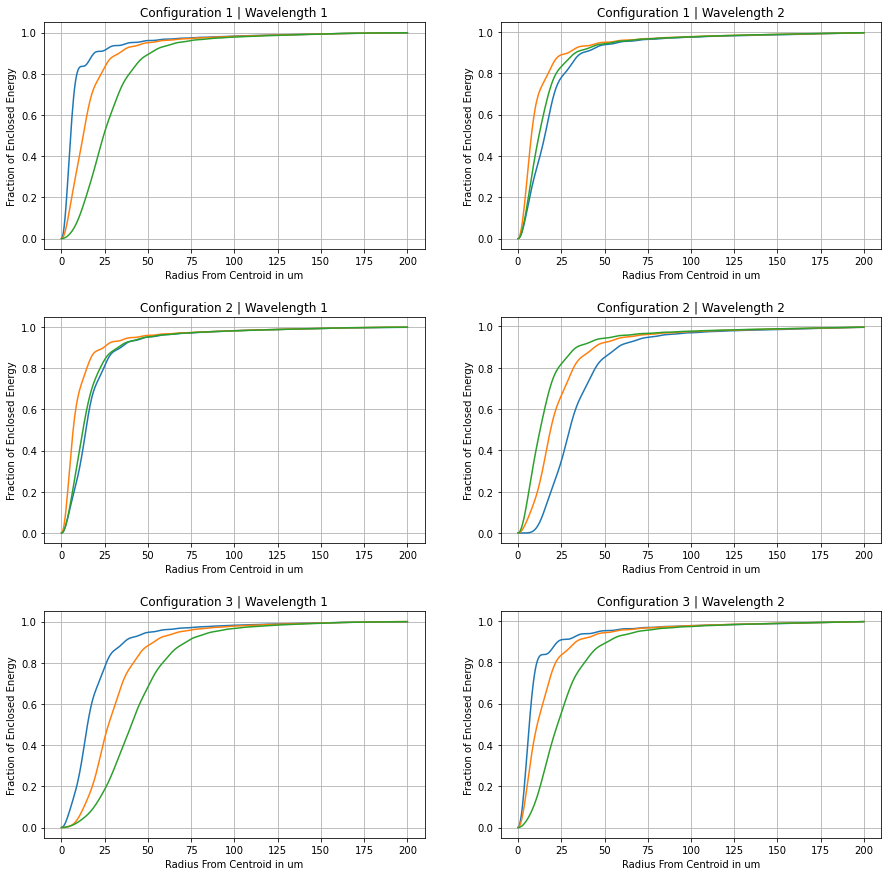

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

# The Multi-Configuration Editor
TheMCE = TheSystem.MCE

# Total number of configurations
NumberOfConfigurations = TheMCE.NumberOfConfigurations

# The Wavelength Data Editor (WDE)
TheWDE = TheSystem.SystemData.Wavelengths

# Total number of wavelengths
NumberOfWavelengths = TheWDE.NumberOfWavelengths

# Create a dummy Diffraciton Encircled Energy (DEE) to retrieve the settings
TheDEE = TheSystem.Analyses.New_DiffractionEncircledEnergy()

# Retrieve DEE settings
TheCommonSettings = TheDEE.GetSettings()

# Setup common settings for the loop (the list of settings available can be
# found under the ZOS-API Syntax Help File by searching for the
# IAS_DiffractionEncircledEnergy interface)
TheCommonSettings.Field.UseAllFields()
TheCommonSettings.SampleSize = ZOSAPI.Analysis.SampleSizes.S_256x256
TheCommonSettings.ShowDiffractionLimit = False

# Save the settings to a file
SavePath = TheApplication.SamplesDir + "\\TemporaryDEESettings.cfg"
TheCommonSettings.SaveTo(SavePath)

# Close the dummy DEE analysis
TheDEE.Close()

# Prepare figure for display
fig, axs = plt.subplots(NumberOfConfigurations, NumberOfWavelengths, figsize = (15, 15))
fig.subplots_adjust(hspace=0.3)

for ax in axs.flat:
    ax.set(xlabel='Radius From Centroid in um', ylabel='Fraction of Enclosed Energy')
    
# Loop over the configurations
for ConfigurationIndex in range(1, NumberOfConfigurations+1):
    # Update current configuration
    TheMCE.SetCurrentConfiguration(ConfigurationIndex)
    
    # Loop over the wavelengths
    for WavelengthIndex in range(1, NumberOfWavelengths+1):
        # Create a new DEE analysis
        TheDEE = TheSystem.Analyses.New_DiffractionEncircledEnergy()

        # Apply common settings
        TheSettings = TheDEE.GetSettings()
        TheSettings.LoadFrom(SavePath)

        # Change wavelength settings dynamically
        TheSettings.Wavelength.SetWavelengthNumber(WavelengthIndex)

        # Apply the settings and run the DEE analysis
        TheDEE.ApplyAndWaitForCompletion()

        # Get the DEE analysis results
        TheResults = TheDEE.GetResults()
        
        # Number of data series
        NumberOfDataSeries = TheResults.NumberOfDataSeries
        
        # Retrieve data series, plot them for verification, and save them to a CSV file
        for FieldIndex in range(NumberOfDataSeries):
            # Retrieval part
            XDataSeries = np.asarray(tuple(TheResults.GetDataSeries(FieldIndex).XData.Data))
            YDataSeries = np.asarray(tuple(TheResults.GetDataSeries(FieldIndex).YData.Data))
            
            # Plot part
            axs[ConfigurationIndex-1, WavelengthIndex-1].plot(XDataSeries, YDataSeries)
            axs[ConfigurationIndex-1, WavelengthIndex-1].set_title('Configuration ' +\
                                                                   str(ConfigurationIndex) +\
                                                                   ' | Wavelength ' +\
                                                                   str(WavelengthIndex))
            axs[ConfigurationIndex-1, WavelengthIndex-1].grid()
            
            # Save data to a variable array
            if ConfigurationIndex == 1 and WavelengthIndex == 1 and FieldIndex == 0:
                Data = XDataSeries.reshape((XDataSeries.size, 1))
                Header = 'Radius, '
                
            Data = np.concatenate((Data, YDataSeries.reshape((YDataSeries.size, 1))), axis = 1)
            Header += 'Config ' + str(ConfigurationIndex) + " | Wave: " + str(WavelengthIndex) +\
                      ' | Fie: ' + str(FieldIndex+1) + ', '
            
        # Close the DEE analysis
        TheDEE.Close()
        
# Save data to file
np.savetxt("E:\\test.csv", Data, header = Header[1:-2], comments='', delimiter = ",")
        
# Delete the temporary settings file
if os.path.exists(SavePath):
    os.remove(SavePath)